# Scrap Data from KCDC

## Import

In [169]:
%matplotlib inline

# for figure
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import pandas as pd

import shutil
# importing os module
import os
# import datetime module
import datetime

import re

## Definitions

In [71]:
# your path folder to save results
PATH_FOLDER_SAVE = '../../data'

PATH_CSV_DATA = PATH_FOLDER_SAVE + '/data.csv'

PATH_PAGES_KCDC_UPDATES = os.getcwd() + '/pages_kcdc_updates.json'

PATH_TABLES_KCDC_UPDATES = os.getcwd() + '/tables_kcdc_updates.json'

## Helper functions

In [29]:
# save before scraping
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))


In [13]:
import scrapy
import scrapy.crawler as crawler
from multiprocessing import Process, Queue
from twisted.internet import reactor

# the wrapper to make it run more times
def run_spider(spider):
    '''
    DOESNT WORK WITH LAST VERSION OF SCRAPY OR TWISTED ??? 
    BUG
    function to run several times scraping process
    '''
    def f(q):
        try:
            runner = crawler.CrawlerRunner()
            deferred = runner.crawl(spider)
            deferred.addBoth(lambda _: reactor.stop())
            reactor.run()
            q.put(None)
        except Exception as e:
            q.put(e)

    q = Queue()
    p = Process(target=f, args=(q,))
    p.start()
    result = q.get()
    p.join()

    if result is not None:
        raise result


## Scrap pages links

In [146]:
%%writefile kcdcspider.py
# -*-coding:utf-8 -*

#
# Class to scrap KCDC Tables values for each town/area in South Korea
#

#import
import re
import scrapy

# definitions
URL_ROOT = 'https://www.cdc.go.kr'
NUM_MAX_PAGES = 8
PATH_OUTPUT = 'pages_kcdc_updates.json'
URL_FIRST_PAGE = URL_ROOT + '/board.es?mid=a30402000000&bid=0030&nPage=1'


# Spider Class
class KCDCPageSpider(scrapy.Spider):
    '''
    Spider to scrap all Le Gorafi pages from selected category
    Configure : 
    - KCDCPageSpider.custom_settings : save location 
    - num_max_pages : the number of next page to scrap
    - url_first_page : web page to start with
    '''
    name = "kcdc_updates_page"
    
    custom_settings = {
      'FEED_FORMAT': 'json',
      'FEED_URI': PATH_OUTPUT
    }
    
    num_max_pages = NUM_MAX_PAGES
    
    url_first_page = URL_FIRST_PAGE
    
    def start_requests(self):
        urls = [
                self.url_first_page,
        ]
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)
    
    def parse(self, response):
        #//div[@class="dbody"]/ul/li/a[@title]/@href
        #//div[@class="dbody"]/ul/li/a[contains(@title,"updates")]/@href
        for post in response.xpath(
            '//div[@class="dbody"]/ul/li/a[contains(@title,"updates")]|' + \
            '//div[@class="dbody"]/ul/li/a[contains(@title,"Updates")]'):
            yield {
                'link': URL_ROOT + post.xpath('@href').extract_first()
            }
        # https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=2
        #//a[@class="pageNext"]/@href
        next_page = response.xpath('//a[@class="pageNext"]/@href').get()
        
        if next_page is not None:
            try:
                num_next_page = int(re.search("(?<=\&nPage\=)\d+$", 
                         next_page).group(0))
                
                if (num_next_page < self.num_max_pages):
                    #next_page = response.urljoin(next_page)
                    next_page = URL_ROOT + next_page
                    yield scrapy.Request(next_page, callback=self.parse)
            except:
                next_page = None

Overwriting kcdcspider.py


In [147]:
%%writefile run_kcdc_pages_updates.py
# -*-coding:utf-8 -*

#
# Run scrapy for retrieve updates pages links from KCDC
#

# import
import scrapy
from scrapy.crawler import CrawlerProcess
from kcdcspider import KCDCPageSpider

process = CrawlerProcess()

process.crawl(KCDCPageSpider)
process.start() # the script will block here until the crawling is finished

Overwriting run_kcdc_pages_updates.py


In [148]:
%%time
try:
    # clean (move file if exist)
    clean_file(PATH_PAGES_KCDC_UPDATES)
    # execute external process (FALLBACK for scrapy problem)
    !python run_kcdc_pages_updates.py 
except:
    print("Error run_kcdc_pages_updates !")

File /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/pages_kcdc_updates_20200228_15_09_12.json moved!
2020-02-28 15:09:13 [scrapy.utils.log] INFO: Scrapy 1.8.0 started (bot: scrapybot)
2020-02-28 15:09:13 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.9, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 19.10.0, Python 3.7.6 (default, Jan  8 2020, 13:42:34) - [Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 19.1.0 (OpenSSL 1.1.1d  10 Sep 2019), cryptography 2.8, Platform Darwin-18.7.0-x86_64-i386-64bit
2020-02-28 15:09:13 [scrapy.crawler] INFO: Overridden settings: {'FEED_FORMAT': 'json', 'FEED_URI': 'pages_kcdc_updates.json'}
2020-02-28 15:09:13 [scrapy.extensions.telnet] INFO: Telnet Password: e249551fe9f83555
2020-02-28 15:09:13 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extens

2020-02-28 15:09:15 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=5> (referer: https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=4)
2020-02-28 15:09:15 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=5>
{'link': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366157&tag=&nPage=5'}
2020-02-28 15:09:15 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=5>
{'link': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366142&tag=&nPage=5'}
2020-02-28 15:09:15 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=5>
{'link': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366138&tag=&nPage=5'}
2020-02-28 15:09:15 [scrapy.core.scraper] DEBUG: Scraped

In [149]:
df_pages_kcdc_updates = pd.read_json(PATH_PAGES_KCDC_UPDATES)
df_pages_kcdc_updates

,link
0,https://www.cdc.go.kr/board/board.es?mid=a3040...
1,https://www.cdc.go.kr/board/board.es?mid=a3040...
2,https://www.cdc.go.kr/board/board.es?mid=a3040...
3,https://www.cdc.go.kr/board/board.es?mid=a3040...
4,https://www.cdc.go.kr/board/board.es?mid=a3040...
5,https://www.cdc.go.kr/board/board.es?mid=a3040...
6,https://www.cdc.go.kr/board/board.es?mid=a3040...
7,https://www.cdc.go.kr/board/board.es?mid=a3040...
8,https://www.cdc.go.kr/board/board.es?mid=a3040...
9,https://www.cdc.go.kr/board/board.es?mid=a3040...


In [150]:
# TODO ?
'''# configure scraping
KCDCPageSpider.url_first_page = URL_PAGES_KCDC_UPDATES
KCDCPageSpider.custom_settings = {
      'FEED_FORMAT': 'json',
      'FEED_URI': URL_PAGES_KCDC_UPDATES
    }
KCDCPageSpider.num_max_pages = 1

# clean last output
clean_file(PATH_PAGES_KCDC_UPDATES)
# scraping page urls 
run_spider(KCDCPageSpider)'''
# DOES NOT WORK ANYMORE !


"# configure scraping\nKCDCPageSpider.url_first_page = URL_PAGES_KCDC_UPDATES\nKCDCPageSpider.custom_settings = {\n      'FEED_FORMAT': 'json',\n      'FEED_URI': URL_PAGES_KCDC_UPDATES\n    }\nKCDCPageSpider.num_max_pages = 1\n\n# clean last output\nclean_file(PATH_PAGES_KCDC_UPDATES)\n# scraping page urls \nrun_spider(KCDCPageSpider)"

## Scrap updates tables

In [151]:
%%writefile kcdctablespider.py
# -*-coding:utf-8 -*

#
# Module for scrapy over tables in KCDC
#

# import
import re
import scrapy
from scrapy.loader import ItemLoader
from scrapy.loader.processors import MapCompose, Join, TakeFirst
from w3lib.html import remove_tags


# definitions 
URL_ROOT = 'https://www.cdc.go.kr'
PATH_TABLES_OUTPUT = 'tables_kcdc_updates.json'
URL_FIRST_PAGE = URL_ROOT + '/board.es?mid=a30402000000&bid=0030&nPage=1'

LIST_AREA = ["Seoul",
"Busan",
"Daegu",
"Incheon",
"Gwangju",
"Daejeon",
"Ulsan",
"Sejong",
"Gyeonggi",
"Gangwon",
"Chungbuk",
"Chungnam",
"Cheonbuk",
"Cheonnam",
"Gyeongbuk",
"Gyeongnam",
"Jeju"]

def convert_int(str_in):
    # suppress ","
    str_in = re.sub(',', '', str_in)
    # convert in integer
    return int(str_in)

def find_in_table(response, n_row, n_col):
    search_str = '//tbody/tr/td/p/' + \
        'span[contains(., "Confirmed")]' + \
        '/../../../..//tr[{}]/td[{}]'.format(n_row, n_col) + \
        '/p/span[re:test(.,"^\d")]//text()'

    text_found = response.xpath(search_str).get()
    return text_found 




def find_int_in_table(response, n_row, n_col):
    text_found = find_in_table(response, n_row, n_col)
    if isinstance(text_found, str):
        return convert_int(text_found)
    else:
        return text_found


def find_int_area_in_table(response, area):

    
    #search_str = '//tbody/tr/td/p/span[contains(., "{}")]'.format(area) + \
    #    '/../../../td[2]/p/span[re:test(.,"^\d")]//text()'
    
    search_str = '//tbody/tr[1]/td[1][contains(., "Regions")]/../../' + \
        'tr/td/p/span[contains(., "{}")]'.format(area) + \
        '/../../../td[2]/p/span[re:test(.,"^\d")]//text()'
    text_found = response.xpath(search_str).get()
    
    # if old style table (area in columns)
    if text_found is None:
        # search # of columns
        
        text_col = ''
        I_col_area = 1
        while text_col != None:
            search_str = '//tbody/tr[1]/td[1][contains(., "Place")]' + \
                '/../../tr[2]/td[{}]/p/span/text()'.format(I_col_area)
            text_col = response.xpath(search_str).get()
            if text_col == area:
                break
            I_col_area = I_col_area + 1
            
        #search_str = '//tbody/tr/td/p/span[contains(., "{}")]'.format(area) + \
        #'/../../../../tr[3]/td[3]/p/span[re:test(.,"^\d")]//text()'
        
        # TEST
        #I_col_area = 2
        
        search_str = '//tbody/tr[1]/td[1][contains(., "Place")]/../../' + \
            'tr/td/p/span[contains(., "{}")]'.format(area) + \
            '/../../../../tr[3]/td[{}]'.format(I_col_area + 1) + \
            '/p/span[re:test(.,"^\d")]//text()'  
        
        text_found = response.xpath(search_str).get()
    
    if isinstance(text_found, str):
        return convert_int(text_found)
    else:
        return text_found
    

class KCDCiItem(scrapy.Item):
    '''
    Class item to declare different information to scrap
    and how to process (as input or output)
    '''
    # define the fields for your item here like:
    url = scrapy.Field(output_processor=TakeFirst())
    
    source = scrapy.Field(output_processor=TakeFirst())
    
    date_published = scrapy.Field(
        input_processor=MapCompose(remove_tags),
        output_processor=TakeFirst()
    )
    
    total = scrapy.Field(output_processor=TakeFirst())
    
    
    Seoul = scrapy.Field(output_processor=TakeFirst())   

    Busan = scrapy.Field(output_processor=TakeFirst())  
    Daegu = scrapy.Field(output_processor=TakeFirst())  
    Incheon = scrapy.Field(output_processor=TakeFirst())  
    Gwangju = scrapy.Field(output_processor=TakeFirst())  
    Daejeon = scrapy.Field(output_processor=TakeFirst())  
    Ulsan = scrapy.Field(output_processor=TakeFirst())  
    Sejong = scrapy.Field(output_processor=TakeFirst())  
    Gyeonggi = scrapy.Field(output_processor=TakeFirst())  
    Gangwon = scrapy.Field(output_processor=TakeFirst())  
    Chungbuk = scrapy.Field(output_processor=TakeFirst())  
    Chungnam = scrapy.Field(output_processor=TakeFirst())  
    Cheonbuk = scrapy.Field(output_processor=TakeFirst())  
    Cheonnam = scrapy.Field(output_processor=TakeFirst())  
    Gyeongbuk = scrapy.Field(output_processor=TakeFirst())  
    Gyeongnam = scrapy.Field(output_processor=TakeFirst())  
    Jeju = scrapy.Field(output_processor=TakeFirst())  
    

class KCDCTablesSpider(scrapy.Spider):
    '''
    Spider to scrap tables webpages : 
    - how to find information for scraping
    - which field names to store
    '''
    # Your spider definition
    name = 'tables_kcdc_spider'
    # output definition :
    custom_settings = {
      'FEED_FORMAT': 'json',
      'FEED_URI': PATH_TABLES_OUTPUT
  }
    # urls to scrap
    start_urls = [URL_FIRST_PAGE]
   
    def parse(self, response):
        '''
        Parse definition with xpath which define all patterns to use
        for retrieve information into HTML strings
        '''
        #url	source	author	title	theme	description	date_published	body   
        l = ItemLoader(item=KCDCiItem(), selector=response)
        
        l.add_value('url', response.url)
        
        l.add_value('source', "KCDC")
        
        #l.add_xpath('author', 
        #    "//section[@class='metas container']/span[@class='context']/a")
        
        #l.add_xpath("title", "//h1")
        
        #l.add_xpath("theme", "//a[@rel='category tag']")
        
        #l.add_xpath("description", ".//div[@class='intro']/p")
        
        #l.add_xpath("date_published", 
        #    "//section[@class='metas container']/span[@class='context']",
        #    re="[0-9]+/[0-9]+/[0-9]+")
        
        l.add_xpath("date_published", 
                    '//span[re:test(.,"^Update$")]/../b//text()', 
                    re="[0-9]+-[0-9]+-[0-9]+")
        
        #response.xpath('//tbody/tr/td/p/span[contains(., "Total")]/../../../td[2]/p/span[re:test(.,"^\d")]//text()').get() 
        #flag_total = response.xpath('//tbody/tr/td/p/' + \
        #    'span[contains(., "Confirmed")]' + \
        #    '/../../../..//tr[4]/td[3]/p/span[re:test(.,"^\d")]//text()').get()
        
        # check if more than 1 row of data
        flag_total = find_in_table(response, 4, 3)
        
        if flag_total is not None: # take 3rd row           
            
            flag_sub = response.xpath('//tbody/tr/td/p/' + \
                'span[contains(., "Confirmed")]/../../../..//tr[2]/td[1]' + \
                '/p/span[re:test(.,"^Sub")]//text()').get()
            
            # if sub total exist (don't sum up)
            if flag_sub is not None:
                int_total_2 = find_int_in_table(response, 3, 3)
                int_total_3 = find_int_in_table(response, 4, 3)
            
            else:
                int_2_1 = find_int_in_table(response, 3, 3)
                int_2_2 = find_int_in_table(response, 3, 4)
                int_total_2 = int_2_1 + int_2_2
                int_3_1 = find_int_in_table(response, 4, 3)
                int_3_2 = find_int_in_table(response, 4, 4)
                int_total_3 = int_3_1 + int_3_2
            
            if int_total_3 > int_total_2:
                l.add_value("total", int_total_3)
            else:
                l.add_value("total", int_total_2)
            
            '''l.add_xpath("total", '//tbody/tr/td/p/' + \
                'span[contains(., "Confirmed")]' + \
                '/../../../..//tr[4]/td[3]/p/span[re:test(.,"^\d")]//text()')'''
            
        else: # take 2nd row
            int_total = find_int_in_table(response, 3, 3)
            l.add_value("total", int_total)
            
            '''l.add_xpath("total", '//tbody/tr/td/p/' + \
                'span[contains(., "Confirmed")]' + \
                '/../../../..//tr[3]/td[3]/p/span[re:test(.,"^\d")]//text()')'''
        
        for area in LIST_AREA:
            int_area = find_int_area_in_table(response, area)
            if int_area is not None:
                l.add_value(area, int_area)
        
        '''l.add_xpath("Seoul", 
            '//tbody/tr/td/p/span[contains(., "Seoul")]' + \
                    '/../../../td[2]/p/span[re:test(.,"^\d")]//text()')'''
        
        
        #l.add_xpath("body", "//div[@class='content']/p")
        #l.add_xpath("body", 
        #    '//div[@class="content"]/p[not(script)][not(img)][not(video)][not(strong/a)]//text()')
        
        yield l.load_item()


Overwriting kcdctablespider.py


In [152]:
'//tbody/tr[1]/td[1][contains(., "Place")]' + '/../../tr[2]/td[{}]/p/span/text()'

'//tbody/tr[1]/td[1][contains(., "Place")]/../../tr[2]/td[{}]/p/span/text()'

In [153]:

'//tbody/tr[1]/td[1][contains(., "Place")]/../../tr[2]/td[1]/p/span/text()'



'//tbody/tr[1]/td[1][contains(., "Place")]/../../tr[2]/td[1]/p/span/text()'

In [154]:
isinstance("345", str)

True

In [155]:
'//tbody/tr/td/p/span[contains(., "{}")]' + \
        '/../../../td[2]/p/span[re:test(.,"^\d")]//text()'.format("Seoul")

'//tbody/tr/td/p/span[contains(., "{}")]/../../../td[2]/p/span[re:test(.,"^\\d")]//text()'

In [156]:
int(re.sub(',', '', '1,567'))

1567

In [157]:
# response.xpath('//tbody/tr/td/p/span[contains(., "Total")]/../../../td[2]/p/span[re:test(.,"^\d")]//text()').get()  


In [158]:
'//tbody/tr/td/p/span[contains(., "Seoul"]/../../../td[2]/p/span[re:test(.,"^\d")]//text()'

'//tbody/tr/td/p/span[contains(., "Seoul"]/../../../td[2]/p/span[re:test(.,"^\\d")]//text()'

In [159]:
# //tbody/tr/td/p/span[contains(., "Seoul")]/../../../../tr[3]/td[3]/p/span

In [160]:
%%writefile run_kcdc_tables_updates.py
# -*-coding:utf-8 -*

#
# Run scrapy for retrieve updates tables from KCDC
#

# import
import scrapy
from scrapy.crawler import CrawlerProcess
from kcdctablespider import KCDCTablesSpider
import pandas as pd
import os

# definitions
PATH_PAGES_KCDC_UPDATES = os.getcwd() + '/pages_kcdc_updates.json'

# get urls pages links
df_pages_kcdc_updates = pd.read_json(PATH_PAGES_KCDC_UPDATES)
# define url for scrapy
KCDCTablesSpider.start_urls = df_pages_kcdc_updates["link"].tolist()

# start scraping process
process = CrawlerProcess()
process.crawl(KCDCTablesSpider)
process.start() # the script will block here until the crawling is finished

Overwriting run_kcdc_tables_updates.py


In [161]:
%%time
try:
    # clean (move file if exist)
    clean_file(PATH_TABLES_KCDC_UPDATES)
    # execute external process (FALLBACK for scrapy problem)
    !python run_kcdc_tables_updates.py 
except:
    print("Error run_kcdc_tables_updates !")

File /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/tables_kcdc_updates_20200228_15_09_39.json moved!
2020-02-28 15:09:40 [scrapy.utils.log] INFO: Scrapy 1.8.0 started (bot: scrapybot)
2020-02-28 15:09:40 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.9, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 19.10.0, Python 3.7.6 (default, Jan  8 2020, 13:42:34) - [Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 19.1.0 (OpenSSL 1.1.1d  10 Sep 2019), cryptography 2.8, Platform Darwin-18.7.0-x86_64-i386-64bit
2020-02-28 15:09:40 [scrapy.crawler] INFO: Overridden settings: {'FEED_FORMAT': 'json', 'FEED_URI': 'tables_kcdc_updates.json'}
2020-02-28 15:09:40 [scrapy.extensions.telnet] INFO: Telnet Password: f27a6362ca3b15a4
2020-02-28 15:09:40 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.exte

2020-02-28 15:09:42 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366288&tag=&nPage=3>
{'Chungnam': 1,
 'Daegu': 45,
 'Gwangju': 1,
 'Gyeonggi': 1,
 'Jeju': 1,
 'Seoul': 4,
 'date_published': '2020-02-21',
 'source': 'KCDC',
 'total': 156,
 'url': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366288&tag=&nPage=3'}
2020-02-28 15:09:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366201&tag=&nPage=4> (referer: None)
2020-02-28 15:09:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366247&tag=&nPage=3> (referer: None)
2020-02-28 15:09:42 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366255&tag=&nPage=3>
{'date_published': '2020-02-20',

2020-02-28 15:09:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=365941&tag=&nPage=7> (referer: None)
2020-02-28 15:09:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=365926&tag=&nPage=7> (referer: None)
2020-02-28 15:09:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366157&tag=&nPage=5> (referer: None)
2020-02-28 15:09:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=365901&tag=&nPage=7> (referer: None)
2020-02-28 15:09:42 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366162&tag=&nPage=4> (referer: None)
2020-02-28 15:09:42 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.c

In [162]:
PATH_TABLES_KCDC_UPDATES

'/Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/tables_kcdc_updates.json'

In [171]:
df_tables_kcdc_updates = pd.read_json(PATH_TABLES_KCDC_UPDATES)
df_tables_kcdc_updates = df_tables_kcdc_updates.sort_values(by=['date_published'])
df_tables_kcdc_updates.T

,28,31,26,25,24,22,23,30,21,32,...,8,2,15,7,0,1,4,6,3,5
url,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...,https://www.cdc.go.kr/board/board.es?mid=a3040...
source,KCDC,KCDC,KCDC,KCDC,KCDC,KCDC,KCDC,KCDC,KCDC,KCDC,...,KCDC,KCDC,KCDC,KCDC,KCDC,KCDC,KCDC,KCDC,KCDC,KCDC
date_published,2020-01-31,2020-02-02,2020-02-02,2020-02-02,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-08,...,2020-02-20,2020-02-20,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27
total,4,NaN,NaN,15,16,18,23,24,22,24,...,82,104,82,156,346,556,763,893,1146,1595
Seoul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,30,36,45,55
Busan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,17,38,50,58
Daegu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,45,NaN,NaN,442,499,677,1017
Incheon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2,3,3
Gwangju,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,NaN,NaN,9,9,9,9
Daejeon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,3,3,8


### clean dates

Keep only 1 date by day : keep max total

In [165]:
df_tables_kcdc_updates["url"].tolist()

['https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366299&tag=&nPage=2',
 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366307&tag=&nPage=2',
 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366264&tag=&nPage=3',
 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366350&tag=&nPage=1',
 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366328&tag=&nPage=2',
 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366363&tag=&nPage=1',
 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366338&tag=&nPage=1',
 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366288&tag=&nPage=3',
 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366255&tag=&nPage=3',
 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030

In [189]:
{'marker': "o"}

{'marker': 'o'}

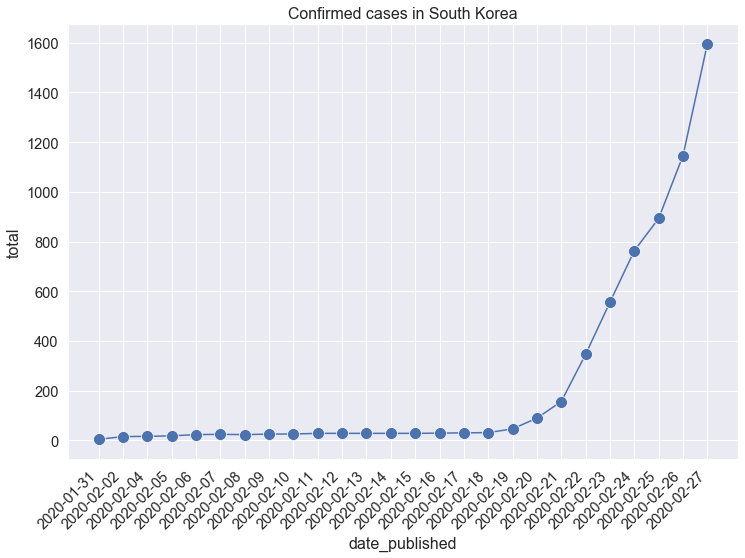

In [202]:
fig = plt.figure(figsize=(12, 8))

g = sns.lineplot(x="date_published", y="total", data=df_tables_kcdc_updates, 
             markersize=12, marker="o");
plt.title("Confirmed cases in South Korea");
#g.get_xticklabels()
#g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'
);

In [200]:
g.get_xticklabels()

<a list of 26 Text xticklabel objects>